# DSCI 632 Final

Your final is to use the dataset of your choice and the techniques in this class to do the following:

1. Define and describe the dataset (10 points)
1. Clean the data (10 points)
1. Transform the clean data (10 points)
1. Show your analysis of the data (10 points)

## Ground Rules

1. Explain everything you're doing with pyspark in the code cells using [markdown](https://www.markdownguide.org/cheat-sheet) in text cells. Help the reader understand why you're doing each step so they can re-create it. Remember, this is an assignment to show how you analyze data to a potential employer. Don't use code comments to explain things.
1. All of the sections are heading 1 in markdown, so use heading 2 to write your explainations, and heading 3 for any sub-headers. Check in your table of contents view in colab to make sure each point is listed before you turn this in.
1. Don't hesisate to use multiple code/text cells in each section, as long as they're all labeled and described.
1. Assume that the reader doesn't have access to the dataset on your local machine. Provide a link to the dataset you're using, or if able, include code to copy it from a public source. Don't rely on uploading from your local machine. (Importing from Google Drive is ok, as long as you provide the link to the data)
1. If using GCP services, include screenshots from your console if there's a step that you aren't able to re-produce in code. Using the SDK is always preferred, but you won't lose points for using screenshots and explaining them.
1. Import the data ONCE, then transform it to fit your analysis.
1. Don't overwrite data, make new columns for new transformations. You can always drop columns later, but you can't get overwritten values back.
1. Feel free to work with classmates, but all work submitted must be your own.
1. Make sure to run disconnect the runtime and re-run the notebook at least once before turning in. If you are getting certain Java runtime errors, this might also help.

## Extra Credit Opportunities!

- If you provide a link to this notebook on your public GitHub page instead of turning it in as an attachment, you will get 2 points extra credit.
- Extra credit will be given for using the [Google Cloud SDK](https://cloud.google.com/sdk/) to create/use/destroy any cloud resources, up to 2 points per section, 8 points total.
 - Don't be afraid to look at the GCP example colab notebooks from the class notes, the GCP documentation, or GitHub for examples.
- If this notebook is self-contained, you will get 5 points extra credit. (Requirements below)
 - The data is imported without relying on Google Drive, as the paths to data in Google Drive are user-specific. Downloads from public storage buckets/services are fine. (1 point)
 - It be run from start to finish without making any changes to paths, code, or variable names. (1 point)
 - All calls to external services, including GCP, are done programatically, no screenshots explaining how it worked in a browser console. (Using an API or SDK, 2 points)
 - All cloud resources are destroyed at the end of the notebook in a seperate section (Also via API or SDK, 1 point)

---

# Section 1: Define and describe the dataset

10 points

Import the dataset, and describe why you'll be analyzing in it. You can summarize a few columns, show a more information on the relavent features, or but help the reader understand what the dataset is, what is in it, and why you picked it.

Some questions that it might help you to answer:
# 1. Why are you choosing this dataset?

- We selected this dataset because it contains information about a superstore's sales and performance indicators, allowing for a variety of analyses relating to sales, profitability, customer behavior, and more. It includes a wide range of factors that may be utilized to gain insights and create data-driven decisions.

- Dataset link = https://www.kaggle.com/datasets/vivek468/superstore-dataset-final

# 2. What variables will you use?

The variables that could be useful for analysis include:

- Order ID: to identify individual orders.
- Order Date: for analyzing trends over time.
- Ship Date: for order fulfillment analysis.
- Ship Mode: for understanding different shipping methods.
- Segment: to analyze sales performance across different customer segments.
- Category: to categorize products and analyze sales by category.
- Sub-Category: to further segment products within categories.
- Sales: to analyze revenue.
- Quantity: for understanding sales volume.
- Discount: to analyze the impact of discounts on sales and profitability.
- Profit: for profitability analysis.
- Region: to analyze sales performance across different regions.

# 3. What analysis(es) will you run?

Potential analyses include:

- We aim to predict sales using numerical and categorical data.

- We will also try to understand the distribution of numerical features.

- We attempt to understand all the distinct features in the categorical columns and how they can impact the sales of the superstore.

# 4. Do you have any hypotheses? What are they?

Hypotheses could include:

- What are the features that are most ideal for predicting sales?
- Do Order Date and Ship Date together impact the sales prediction?

### This section should include one or more of the following:
- A histogram of several features relavent to your analysis
- The schema of the dataset, with the datatypes assigned correctly
- A text cell with explainations of the relavent features in [markdown](https://www.markdownguide.org/cheat-sheet)
- Use Spark SQL or built-in methods to show a range of values
- Most common words/n-grams found

In [74]:
# Install Spark 3.5.0
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz


In [75]:
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

# Install Findspark
!pip install -q findspark

import findspark
findspark.init()

## creating a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Final').getOrCreate()

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

import seaborn as sns
from pyspark.sql.functions import col, split, explode
from pyspark.ml.feature import NGram

from pyspark.sql.functions import col, lower
from pyspark.sql.types import StringType

from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline


In [77]:
df = spark.read.csv("/content/Superstore.csv", header=True, inferSchema=True)
df_filtered = df.filter(~col('Sales').rlike('[a-zA-Z]'))
df_filtered.show()


+------+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|     Customer Name|    Segment|      Country|           City|         State|Postal Code| Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+------+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|     1|CA-2016-152156| 11/8/2016|11/11/2016|  Second Class|   CG-12520|       Claire Gute|   Consumer|United States|      Henderson|      Kentucky|      42420|  South|FUR-BO-10001798|   

### The sales column had some values like ' Blue', ' Canary' etc. We remove any text values that exist in the sale column to ensure that it does not affect the prediction.

In [78]:
df_filtered = df_filtered.dropna()

In [79]:
df = df_filtered

In [80]:
df.printSchema()

root
 |-- Row ID: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Ship Date: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- Profit: double (nullable = true)



In [81]:

df.describe().show()


+-------+-----------------+--------------+----------+---------+--------------+-----------+------------------+-----------+-------------+--------+-------+-----------------+-------+---------------+----------+------------+--------------------+------------------+------------------+-------------------+------------------+
|summary|           Row ID|      Order ID|Order Date|Ship Date|     Ship Mode|Customer ID|     Customer Name|    Segment|      Country|    City|  State|      Postal Code| Region|     Product ID|  Category|Sub-Category|        Product Name|             Sales|          Quantity|           Discount|            Profit|
+-------+-----------------+--------------+----------+---------+--------------+-----------+------------------+-----------+-------------+--------+-------+-----------------+-------+---------------+----------+------------+--------------------+------------------+------------------+-------------------+------------------+
|  count|             9694|          9694|      9

### In the above the cells, we drop any null values if they exist, describe the dataset and understand its schema.

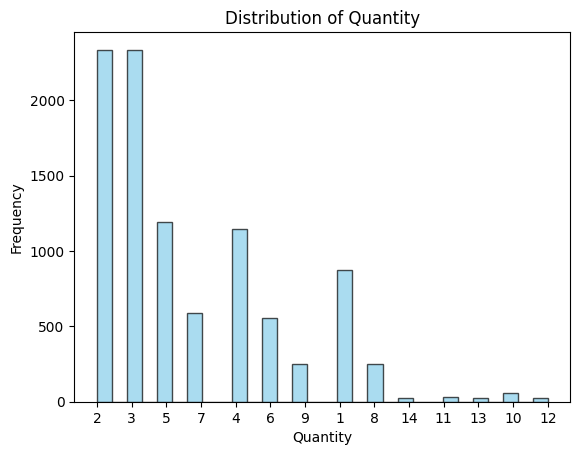

In [82]:
quantity = df.select('Quantity').rdd.flatMap(lambda x: x).collect()

plt.hist(quantity, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

We visualize the distribution of quantity.


*   Quantity - Majority of the people tend to buy items between 1-9, that accounts for over 75% of the store sales. This suggests that the store may be a convenience superstore that only sells a range of items. Only about 25% of the people buy 10 items or more.



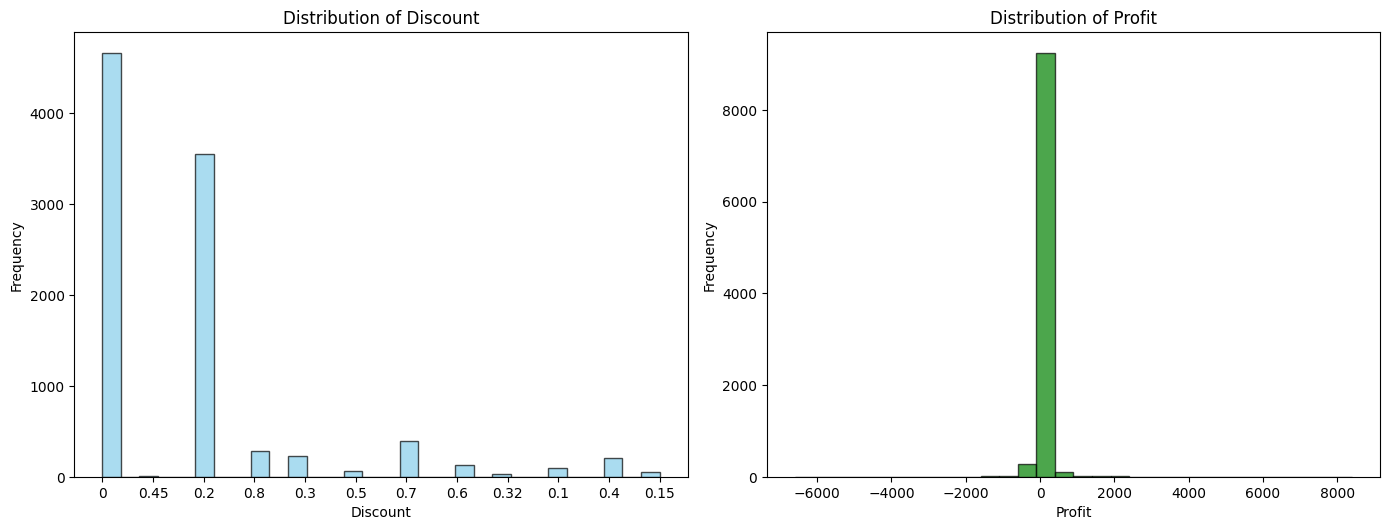

In [83]:
discount = df.select('Discount').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 3)
plt.hist(discount, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Discount')
plt.xlabel('Discount')
plt.ylabel('Frequency')

profit = df.select('Profit').rdd.flatMap(lambda x: x).collect()

plt.subplot(2, 2, 4)
plt.hist(profit, bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Profit')
plt.xlabel('Profit')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## We visualize the distribution of Discount and Profit.

### *   Discount -  We see that majority of the products sold have non discount, and the second most is 0.2, which suggests that at least over 50% of the items were discounted at 20%
### *   Profit - We can observe that the store was profitable through the distribution, The range of profit fits over 0-200 and the frequency is immense compared to the loss.



In [84]:

df.createOrReplaceTempView("superstore")

print("\nRange of values for 'Category' column:")
spark.sql("SELECT DISTINCT Category FROM superstore").show()

print("\nRange of values for 'Sub-Category' column:")
spark.sql("SELECT DISTINCT 'Sub-Category' FROM superstore").show()

print("\nRange of values for 'Ship Mode' column:")
spark.sql("SELECT DISTINCT 'Ship Mode' FROM superstore").show()

print("\nRange of values for 'Segment' column:")
spark.sql("SELECT DISTINCT Segment FROM superstore").show()

print("\nRange of values for 'Region' column:")
spark.sql("SELECT DISTINCT Region FROM superstore").show()



Range of values for 'Category' column:
+---------------+
|       Category|
+---------------+
|Office Supplies|
|      Furniture|
|     Technology|
+---------------+


Range of values for 'Sub-Category' column:
+------------+
|Sub-Category|
+------------+
|Sub-Category|
+------------+


Range of values for 'Ship Mode' column:
+---------+
|Ship Mode|
+---------+
|Ship Mode|
+---------+


Range of values for 'Segment' column:
+-----------+
|    Segment|
+-----------+
|   Consumer|
|Home Office|
|  Corporate|
+-----------+


Range of values for 'Region' column:
+-------+
| Region|
+-------+
|  South|
|Central|
|   East|
|   West|
+-------+



## We set up a temporary SQL view, which allows us to query the data using SQL syntax. The code then does a series of SELECT DISTINCT queries on the columns 'Category', 'Sub-Category', 'Ship Mode', 'Segment', and 'Region' to find all of the unique values in each of these columns.

### These queries help to understand the variety of data

### We identify all of the values that appear in categorical columns, this is useful information since these categorical values must be One-Hot encoded for training and testing.





In [85]:
ngram_df = df.select('Product Name').withColumn('words', split(col('Product Name'), ' '))

unigram = NGram(n=1, inputCol='words', outputCol='unigrams')
unigram_df = unigram.transform(ngram_df)
unigram_freq = unigram_df.select(explode('unigrams').alias('unigram')).groupBy('unigram').count().orderBy(col('count').desc())
print("\nTop 10 most common unigrams:")
unigram_freq.show(10)



Top 10 most common unigrams:
+-------+-----+
|unigram|count|
+-------+-----+
|  Xerox|  859|
|  Avery|  526|
|   with|  477|
|      x|  473|
|    for|  465|
|Binders|  451|
|  Black|  335|
|  Chair|  325|
|    GBC|  325|
|Binding|  324|
+-------+-----+
only showing top 10 rows



In [86]:
bigram = NGram(n=2, inputCol='words', outputCol='bigrams')
bigram_df = bigram.transform(ngram_df)
bigram_freq = bigram_df.select(explode('bigrams').alias('bigram')).groupBy('bigram').count().orderBy(col('count').desc())
print("\nTop 10 most common bigrams:")
bigram_freq.show(10)


Top 10 most common bigrams:
+-----------------+-----+
|           bigram|count|
+-----------------+-----+
|     Ring Binders|  161|
|     Wilson Jones|  148|
|      Wall Clock"|  110|
|   Binding System|  100|
| Pencil Sharpener|   92|
|  Electric Pencil|   90|
|       VoIP phone|   78|
|Desk Accessories,|   78|
|  Binding Machine|   74|
|Conference Tables|   71|
+-----------------+-----+
only showing top 10 rows



### We examine the frequency of words and word pairs (unigrams and bigrams) in product names obtained from a dataset.

### It initially divides the product names into separate words before generating unigrams and bigrams from them. It then determines the frequency of each unigram and bigram, in descending order of appearance.

### Finally, it provides the top ten most common unigrams and bigrams, revealing the most often used phrases and term pairings in product names.

# Section 2: Clean the data

10 points

Not every dataset is going to be ready to use right away. Take steps to fix incorrect inputs, remove null values, and assign datatypes that fit each feature.

### This section should include one or more of the following:
- A count of rows before and after dropping data with null or incorrect values, including an explaination of why removing the rows was necessary in [markdown](https://www.markdownguide.org/cheat-sheet).
- Renaming a column, adding a new one, or casting an existing one as a different datatype.
- Remove punctuation marks, symbols, etc from the data, and convert all upper-case lettering to lower-case.
- Remove or fix rows that have bad values/data.

In [87]:

print("Count of missing values:")
df_cleaned = df.na.drop()

print("\nCount of rows before dropping missing values:", df.count())
print("Count of rows after dropping missing values:", df_cleaned.count())


Count of missing values:

Count of rows before dropping missing values: 9694
Count of rows after dropping missing values: 9694


### This sample counts and presents the amount of missing values in each column, indicating columns where data may be missing or empty. It then eliminates any rows with missing values.

### Finally, it compares and shows the total row counts before and after the cleaning process.

In [88]:
for column in df_cleaned.columns:
    print(f"Column: {column}, DataType: {df_cleaned.schema[column].dataType}")

    if isinstance(df_cleaned.schema[column].dataType, StringType):
        df_cleaned = df_cleaned.withColumn(column, lower(col(column)))


Column: Row ID, DataType: IntegerType()
Column: Order ID, DataType: StringType()
Column: Order Date, DataType: StringType()
Column: Ship Date, DataType: StringType()
Column: Ship Mode, DataType: StringType()
Column: Customer ID, DataType: StringType()
Column: Customer Name, DataType: StringType()
Column: Segment, DataType: StringType()
Column: Country, DataType: StringType()
Column: City, DataType: StringType()
Column: State, DataType: StringType()
Column: Postal Code, DataType: IntegerType()
Column: Region, DataType: StringType()
Column: Product ID, DataType: StringType()
Column: Category, DataType: StringType()
Column: Sub-Category, DataType: StringType()
Column: Product Name, DataType: StringType()
Column: Sales, DataType: StringType()
Column: Quantity, DataType: StringType()
Column: Discount, DataType: StringType()
Column: Profit, DataType: DoubleType()


In [89]:
df_cleaned.show()

+------+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|     Customer Name|    Segment|      Country|           City|         State|Postal Code| Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+------+--------------+----------+----------+--------------+-----------+------------------+-----------+-------------+---------------+--------------+-----------+-------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|     1|ca-2016-152156| 11/8/2016|11/11/2016|  second class|   cg-12520|       claire gute|   consumer|united states|      henderson|      kentucky|      42420|  south|fur-bo-10001798|   

### We go through each column and share its name and data type. It transforms the text of columns that contain string data to lowercase.

### This transformation standardizes string values, which may benefit with data consistency and comparison processes.

In [90]:

columns_to_drop = ['Order ID', 'Customer ID', 'Product ID', 'Postal Code', 'City', 'Customer Name', 'Order Date', 'Country']
df_clean = df_cleaned.select([column for column in df_cleaned.columns if column not in columns_to_drop])

df_clean = df_clean.withColumn("Quantity", df_clean["Quantity"].cast("float"))
df_clean = df_clean.withColumn("Discount", df_clean["Discount"].cast("float"))
df_clean = df_clean.withColumn("Sales", df_clean["Sales"].cast("float"))

In [91]:
df_clean.show()

+------+----------+--------------+-----------+--------------+-------+---------------+------------+--------------------+--------+--------+--------+--------+
|Row ID| Ship Date|     Ship Mode|    Segment|         State| Region|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+------+----------+--------------+-----------+--------------+-------+---------------+------------+--------------------+--------+--------+--------+--------+
|     1|11/11/2016|  second class|   consumer|      kentucky|  south|      furniture|   bookcases|bush somerset col...|  261.96|     2.0|     0.0| 41.9136|
|     2|11/11/2016|  second class|   consumer|      kentucky|  south|      furniture|      chairs|hon deluxe fabric...|  731.94|     3.0|     0.0| 219.582|
|     3| 6/16/2016|  second class|  corporate|    california|   west|office supplies|      labels|self-adhesive add...|   14.62|     2.0|     0.0|  6.8714|
|     4|10/18/2015|standard class|   consumer|       florida|  s

### Above we tidy up the dataset by deleting certain columns that might not be needed for further analysis or modeling, such as IDs and geographical information.

### We then verify that all of the columns indicating quantities, discounts, and sales are handled as floating-point values, which is critical for any subsequent computations or modeling.

# Section 3: Transform the clean data

10 points

Once you have clean data, start to prepare it to fit your analysis tools. This might mean using custom code to normalize certain values, joining supplemental datasets, and/or preparing it for machine learning.

### This section should include one or more of the following:
- Write a UDF to perform a function, then use it to add a new column to your data. Explain why in [markdown](https://www.markdownguide.org/cheat-sheet)
- Join an outside data source. (It can be one you've prepared alongside the primary source you're using, as long as you link it)
- Split the data into train/test sets
- Create vectors for relavent features
- One-hot encode catagorical variables

In [92]:
def profit_per_quantity(profit, quantity):
    return profit / quantity


In [93]:
profit_per_quantity_udf = udf(profit_per_quantity, FloatType())
df_clean = df_clean.withColumn('Profit Per Quantity', profit_per_quantity_udf(col('Profit'), col('Quantity')))
df_clean.show()

+------+----------+--------------+-----------+--------------+-------+---------------+------------+--------------------+--------+--------+--------+--------+-------------------+
|Row ID| Ship Date|     Ship Mode|    Segment|         State| Region|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|Profit Per Quantity|
+------+----------+--------------+-----------+--------------+-------+---------------+------------+--------------------+--------+--------+--------+--------+-------------------+
|     1|11/11/2016|  second class|   consumer|      kentucky|  south|      furniture|   bookcases|bush somerset col...|  261.96|     2.0|     0.0| 41.9136|            20.9568|
|     2|11/11/2016|  second class|   consumer|      kentucky|  south|      furniture|      chairs|hon deluxe fabric...|  731.94|     3.0|     0.0| 219.582|             73.194|
|     3| 6/16/2016|  second class|  corporate|    california|   west|office supplies|      labels|self-adhesive add...| 

 ## First, we define a UDF named `profit_per_quantity` that divides profit by quantity, aiming to understand the profitability of each sold item.

 ## Applying this UDF to the `df_clean` DataFrame, it creates a new column, 'Profit_Per_Quantity'.

In [94]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline


Categorical_Columns = ['Category', 'Sub-Category', 'Region', 'Ship Date', 'Product Name', 'Segment', 'Ship Mode', 'State']
indexers = [StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col)) for col in Categorical_Columns]
encoders = [OneHotEncoder(inputCols=[idx.getOutputCol()], outputCols=["{0}_encoded".format(idx.getInputCol())]) for idx in indexers]


In [95]:
pipeline = Pipeline(stages=indexers + encoders)
df_transformed = pipeline.fit(df_clean).transform(df_clean)

Required_Columns = [col for col in df_transformed.columns if col not in Categorical_Columns]
Required_Columns = [col for col in Required_Columns if not col.endswith("_indexed")]

In [96]:
df_final = df_transformed.select(Required_Columns)
df_final.show()

+------+--------+--------+--------+--------+-------------------+----------------+--------------------+--------------+-------------------+--------------------+---------------+-----------------+---------------+
|Row ID|   Sales|Quantity|Discount|  Profit|Profit Per Quantity|Category_encoded|Sub-Category_encoded|Region_encoded|  Ship Date_encoded|Product Name_encoded|Segment_encoded|Ship Mode_encoded|  State_encoded|
+------+--------+--------+--------+--------+-------------------+----------------+--------------------+--------------+-------------------+--------------------+---------------+-----------------+---------------+
|     1|  261.96|     2.0|     0.0| 41.9136|            20.9568|   (2,[1],[1.0])|     (16,[12],[1.0])|     (3,[],[])| (1331,[974],[1.0])| (1797,[1139],[1.0])|  (2,[0],[1.0])|    (3,[1],[1.0])|(48,[16],[1.0])|
|     2|  731.94|     3.0|     0.0| 219.582|             73.194|   (2,[1],[1.0])|      (16,[7],[1.0])|     (3,[],[])| (1331,[974],[1.0])|   (1797,[35],[1.0])|  (2,[

### We determine the categorical columns that will be altered. Then it utilizes 'StringIndexer' to turn each category column into numerical indices, and 'OneHotEncoder' to convert these indices into a binary vector representation, making the data more suited for algorithms that need numerical input.

### A pipeline is built to expedite the transformation process. After processing the data, it removes the original and intermediate categorical columns, leaving just the encoded features and numerical columns.

In [97]:
df_final = df_final.drop('Row ID')

In [98]:
(train_data, test_data) = df_final.randomSplit([0.8, 0.2], seed=1234)

print('Train Data Count: ',train_data.count())
print('Test Data Count: ',test_data.count())



Train Data Count:  7771
Test Data Count:  1923


In [99]:
train_data.show()

+-----+--------+--------+-------+-------------------+----------------+--------------------+--------------+-------------------+--------------------+---------------+-----------------+---------------+
|Sales|Quantity|Discount| Profit|Profit Per Quantity|Category_encoded|Sub-Category_encoded|Region_encoded|  Ship Date_encoded|Product Name_encoded|Segment_encoded|Ship Mode_encoded|  State_encoded|
+-----+--------+--------+-------+-------------------+----------------+--------------------+--------------+-------------------+--------------------+---------------+-----------------+---------------+
|0.444|     1.0|     0.8|  -1.11|              -1.11|   (2,[0],[1.0])|      (16,[8],[1.0])| (3,[2],[1.0])| (1331,[290],[1.0])| (1797,[1202],[1.0])|  (2,[0],[1.0])|    (3,[0],[1.0])| (48,[2],[1.0])|
|0.836|     1.0|     0.8|-1.3376|            -1.3376|   (2,[0],[1.0])|      (16,[0],[1.0])| (3,[2],[1.0])| (1331,[291],[1.0])|  (1797,[128],[1.0])|  (2,[1],[1.0])|    (3,[0],[1.0])| (48,[5],[1.0])|
|0.852|   

### We drop the Row ID column because we do not need it for our analysis, and then we view the train data to make sure its clean and ready for training

# Section 4: Show your analysis of the data

10 points

This is where the science happens. Use your data to show some kind of insight, and how you got there. Make the reader understand why it's important, and how they can get the same conslusion, and/or what would need to change to reach a different one.

### This section should include one or more of the following:
- Fit the data to a model
- Show the outcome of clustering, regression, and/or classification algorithms.
 - We used several in class, but you can use whatever fits your needs for this assignment
- Reccomend a product/item
- Use a SQL query to filter results


In [100]:
feature_Columns = [col for col in df_final.columns if col.endswith('_encoded') or col in ['Profit Per Quantity', 'Discount', 'Profit', 'Quantity']]  # Modify as per your dataset

assembler = VectorAssembler(inputCols=feature_Columns, outputCol="features")

linreg = LinearRegression(featuresCol="features", labelCol="Sales")
pipeline = Pipeline(stages=[assembler, linreg])
model = pipeline.fit(train_data)
predictions = model.transform(test_data)
predictions.select("prediction", "Sales", "features").show(30)


+-------------------+-----+--------------------+
|         prediction|Sales|            features|
+-------------------+-----+--------------------+
|-236.13083552126238|0.556|(3206,[0,1,2,3,4,...|
|-186.60522303379372|0.876|(3206,[0,1,2,3,4,...|
|-104.56311502097118|1.272|(3206,[0,1,2,3,4,...|
| -112.3120192806734|1.344|(3206,[0,1,2,3,4,...|
| -33.58832072943072|1.344|(3206,[0,1,2,3,4,...|
| -83.31257042127727|1.362|(3206,[0,1,2,3,4,...|
|-146.19251927709422|1.365|(3206,[0,1,2,3,4,...|
|-30.155778187606572|1.556|(3206,[0,1,2,3,4,...|
|-107.82034746086377|1.696|(3206,[0,1,2,3,4,...|
| -256.7695638375659|1.728|(3206,[0,1,2,3,4,...|
|-141.72405484930061| 1.78|(3206,[0,2,3,4,11...|
|   11.4622184037148|  1.8|(3206,[0,1,2,3,4,...|
|-171.08799130525824| 1.81|(3206,[0,2,3,4,19...|
|-133.22155032576921| 1.81|(3206,[0,2,3,4,19...|
| -261.3654326645797|1.872|(3206,[0,1,2,3,4,...|
|  72.04249765010708|1.908|(3206,[0,1,2,3,4,...|
|-114.13219753752092| 1.98|(3206,[0,2,3,12,2...|
|  49.55258732597005

### Using a Spark DataFrame, we create and execute a linear regression model to predict sales data. We determine which columns should serve as input features, including those that have been one-hot encoded and numerical columns such as 'Profit_Per_Quantity', 'Discount', 'Profit', and 'Quantity'.

### These characteristics are then combined into a single vector for each record using the 'VectorAssembler'. Then a linear regression model is created, with 'Sales' as the primary variable to predict.

### Linear regression—is structured into a pipeline, which is a simplified approach for fitting the model to training data and then applying it to test data to make sales forecasts.

### Finally, we have a comparison of the model's predictions to actual sales representations for evaluation.

### We observe that the predictions are not up to par, this may be due to the lack of feature engineering or hyperparameter turning.

In [101]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluatorRMSE = RegressionEvaluator(labelCol="Sales", predictionCol="prediction", metricName="rmse")
evaluatorMAE = RegressionEvaluator(labelCol="Sales", predictionCol="prediction", metricName="mae")
evaluatorR2 = RegressionEvaluator(labelCol="Sales", predictionCol="prediction", metricName="r2")

rmse = evaluatorRMSE.evaluate(predictions)
mae = evaluatorMAE.evaluate(predictions)
r2 = evaluatorR2.evaluate(predictions)

print('Root Mean Squared Error (RMSE): ',rmse)
print('Mean Absolute Error (MAE): ',mae)
print('R-squared: ',r2)

Root Mean Squared Error (RMSE):  257.8746582271462
Mean Absolute Error (MAE):  140.32161348059864
R-squared:  0.8213205651351116


### We compute three metrics: The RMSE (257.87) indicates how much the projections depart from the actual sales statistics. MAE (140.32) calculates the average error magnitude without squaring differences. Finally, R-squared (0.82) determines how well the predictions match the actual data, with a value around 1 indicating a perfect fit.

## Final Analysis and thoughts:

### - I took the superstore sales dataset from Kaggle, because it is heavily researched and serves as a perfect baseline for this assignment

### - The dataset was clean, not any null values, but the sales column had a few anomalies, so we iterated through them and removed it.

### - We then understand the range of values for categorical columns which provides insights on the scale of the superstore's operations. We also convert all the values to lowercase for those fields of type string.

### - Now comes the fun part, we hypothesize the important features that may help in predicting sales, most of them are categorical so we have to One-hot encode them for training and testing purposes.

### - The training results are not satisfactory, but it gives us a good idea about how to improve it further.